In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import os
from torchvision.transforms import v2
from tqdm.auto import tqdm
import torchmetrics
import torchvision

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
torch.set_float32_matmul_precision('high')

In [6]:
device

device(type='cuda')

In [7]:
train_dir = os.path.join('dog-breed-identification', 'train')

In [137]:
df = pd.read_csv(os.path.join('dog-breed-identification', 'labels.csv'))
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [138]:
df['id'] = df['id'].apply(lambda x: os.path.join(train_dir, x + '.jpg'))

In [139]:
df.head()

,id,breed
0,dog-breed-identification/train/000bec180eb18c7...,boston_bull
1,dog-breed-identification/train/001513dfcb2ffaf...,dingo
2,dog-breed-identification/train/001cdf01b096e06...,pekinese
3,dog-breed-identification/train/00214f311d5d224...,bluetick
4,dog-breed-identification/train/0021f9ceb3235ef...,golden_retriever


In [140]:
df['breed'].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

In [141]:
val_ratio = int(len(df)*0.1)
index = np.random.choice(len(df) - 1, replace=False, size=val_ratio)
df_train = df.drop(index)
df_test = df.iloc[index]

In [142]:
len(df_train)

9200

In [143]:
len(df_test)

1022

In [144]:
class Cutout(object):
    def __init__(self, n_holes, length, prob=0.5):
        self.n_holes = n_holes
        self.length = length
        self.prob = prob

    def __call__(self, img):
        
        if np.random.rand() > self.prob:
            return img
        
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [16]:
transforms_train = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.3),
        v2.RandomRotation(20),
        v2.Resize((224, 224), antialias=True),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
        Cutout(1, 56)
    ]
)

In [17]:
transforms_test=  v2.Compose(
    [
        v2.Resize((224, 224), antialias=True),
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
    ]
)

In [18]:
len(df_train)

9200

In [19]:
df.iloc[2, 0]

'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg'

In [20]:
df.shape

(10222, 2)

In [21]:
class DogDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, target_transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.target_transforms = target_transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.df.iloc[index, 0]
        img = read_image(img_path)
        label = self.df.iloc[index, 1]
        if self.transforms:
            img = self.transforms(img)
        if self.target_transforms:
            label = self.target_transforms(label)

        return img, label

    

In [22]:
labels = sorted(df['breed'].unique())
label_to_int = {label: i for i, label in enumerate((labels))}
int_to_label = {i: label for i, label in enumerate((labels))}

In [23]:
label_to_int

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [24]:
int_to_label

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [25]:
dataset_train = DogDataset(df_train, train_dir, transforms=transforms_train, target_transforms=lambda x: label_to_int[x])

In [26]:
dataset_test = DogDataset(df_test, train_dir, transforms=transforms_test, target_transforms=lambda x: label_to_int[x])

In [27]:
NUM_WORKERS = 6
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

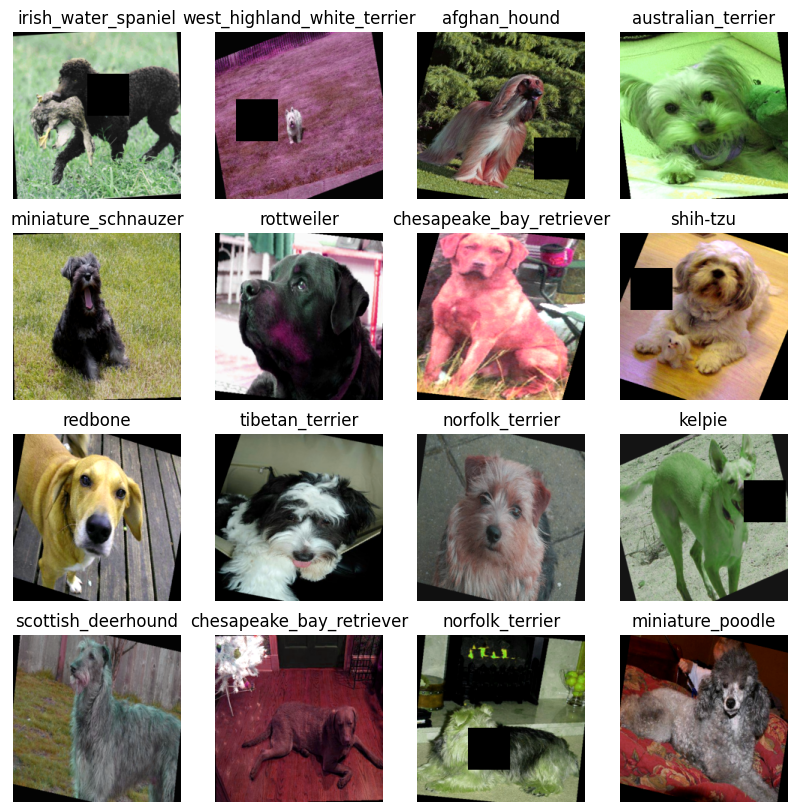

In [28]:
figure = plt.figure(figsize=(10,10))
cols, rows = 4, 4
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(int_to_label[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

In [29]:
len(train_loader), len(test_loader)

(288, 32)

In [40]:
def accuracy_output(outputs, labels):
    with torch.no_grad():
        _, preds = torch.max(outputs, dim=1)
        return torch.sum(preds == labels).item() / len(preds)

In [68]:
def train_model(model, optimizer, train_loader, loss_fn, accuracy, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), num_epochs=20):
    model.to(device)
    model.train()
    train_accs, train_loss = list(), list()
    for epoch in tqdm(range(num_epochs)):
        for batch, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)            
            loss.backward()

            optimizer.step()
            train_accs.append(accuracy(outputs, labels))
            train_loss.append(loss.item())
            if batch % 96 == 0:
                avg_acc = (torch.sum(torch.tensor(train_accs))) / (len(train_accs))
                avg_loss = (torch.sum(torch.tensor(train_loss)) / len(train_loss))
                print(f'Test Batch: {batch}, Loss: {avg_loss}, Accuracy: {avg_acc}')



        

In [69]:
def test_model(model, test_loader, loss_fn, device):
    
    model.to(device)
    model.eval()
    total_loss, total_correct, size = 0, 0, 0
    with torch.inference_mode():
        for batch, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, y_preds_test = torch.max(outputs, dim=1)
            correct = (y_preds_test == labels).sum().item()
            size += labels.size(0)
            total_correct += correct

            if batch % 100 == 0:
                print(f'Test Batch {batch}, Loss: {loss.item()}, Accuracy: {correct / len(labels)}')

    total_loss /= len(test_loader)
    acc_perc = total_correct / size
    print(f'Total Loss: {total_loss}, Total Accuracy: {acc_perc}')

In [70]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)
model.classifier = nn.Linear(1280, len(labels))
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [72]:
train_model(model, optimizer, train_loader, loss_fn, num_epochs=30)

TypeError: train_model() missing 1 required positional argument: 'accuracy'

In [73]:
test_model(model, test_loader, loss_fn)

TypeError: test_model() missing 1 required positional argument: 'device'

In [74]:
#torch.save(model, "model.pt")

In [75]:
y_true = []
y_pred = []
 
with torch.inference_mode():
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)

        y_true.extend(labels.cpu().numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

In [76]:
from sklearn.metrics import f1_score, accuracy_score

print(f'F1 Score: {f1_score(y_true, y_pred, average="weighted"):.3f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f}')

F1 Score: 0.001
Accuracy: 0.007


In [77]:
model = torch.load("model.pt")

In [78]:
model_compiled = torch.compile(model)

In [84]:
train_model(model_compiled, optimizer, train_loader, loss_fn, accuracy_output, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Batch: 0, Loss: 0.8463524580001831, Accuracy: 0.84375
Test Batch: 96, Loss: 0.8637056350708008, Accuracy: 0.7980026006698608
Test Batch: 192, Loss: 0.8603360652923584, Accuracy: 0.7990608811378479
Test Batch: 0, Loss: 0.8599855303764343, Accuracy: 0.7968209385871887
Test Batch: 96, Loss: 0.8639798760414124, Accuracy: 0.7915584444999695
Test Batch: 192, Loss: 0.864553689956665, Accuracy: 0.7917749285697937
Test Batch: 0, Loss: 0.8608095645904541, Accuracy: 0.7924068570137024
Test Batch: 96, Loss: 0.85907381772995, Accuracy: 0.7926727533340454
Test Batch: 192, Loss: 0.8606190085411072, Accuracy: 0.7919782400131226
Test Batch: 0, Loss: 0.8587089776992798, Accuracy: 0.7924855351448059
Test Batch: 96, Loss: 0.8581228852272034, Accuracy: 0.7932167053222656
Test Batch: 192, Loss: 0.859366238117218, Accuracy: 0.7929280996322632
Test Batch: 0, Loss: 0.8592294454574585, Accuracy: 0.7929585576057434
Test Batch: 96, Loss: 0.8595708608627319, Accuracy: 0.7927342057228088
Test Batch: 192, Loss:

In [119]:
y_true = []
y_pred = []
 
with torch.inference_mode():
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)

        y_true.extend(labels.cpu().numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

In [120]:
print(f'F1 Score: {f1_score(y_true, y_pred, average="weighted"):.3f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f}')

F1 Score: 0.853
Accuracy: 0.857


In [121]:
test_model(model, test_loader, loss_fn, device)

Test Batch 0, Loss: 0.7187851667404175, Accuracy: 0.8125
Total Loss: 0.6202782494947314, Total Accuracy: 0.8571428571428571


In [122]:
#torch.save(model, "model.pt")

In [123]:
y_pred

[60,
 25,
 101,
 64,
 30,
 91,
 26,
 69,
 42,
 15,
 28,
 63,
 101,
 114,
 92,
 116,
 27,
 37,
 52,
 78,
 1,
 105,
 30,
 63,
 31,
 106,
 2,
 93,
 95,
 65,
 97,
 97,
 87,
 79,
 36,
 17,
 90,
 92,
 0,
 7,
 102,
 67,
 70,
 21,
 54,
 48,
 93,
 69,
 4,
 59,
 17,
 79,
 22,
 90,
 103,
 17,
 57,
 109,
 47,
 14,
 85,
 33,
 16,
 1,
 117,
 2,
 110,
 14,
 15,
 13,
 60,
 41,
 100,
 112,
 11,
 14,
 110,
 69,
 39,
 10,
 107,
 98,
 21,
 68,
 69,
 19,
 40,
 86,
 58,
 70,
 81,
 2,
 118,
 72,
 92,
 55,
 101,
 65,
 60,
 81,
 99,
 101,
 13,
 113,
 32,
 94,
 99,
 93,
 61,
 1,
 87,
 88,
 37,
 98,
 72,
 75,
 78,
 7,
 11,
 55,
 81,
 38,
 31,
 93,
 11,
 100,
 11,
 20,
 41,
 85,
 2,
 9,
 94,
 7,
 24,
 82,
 63,
 53,
 43,
 101,
 118,
 10,
 2,
 41,
 39,
 70,
 82,
 7,
 22,
 100,
 23,
 48,
 56,
 24,
 39,
 114,
 90,
 106,
 71,
 58,
 70,
 36,
 14,
 80,
 115,
 83,
 45,
 72,
 110,
 108,
 84,
 69,
 56,
 81,
 62,
 67,
 114,
 23,
 94,
 78,
 20,
 44,
 6,
 116,
 98,
 58,
 56,
 86,
 70,
 44,
 2,
 97,
 93,
 104,
 45,
 35,
 118,


In [124]:
y_true

[116,
 14,
 43,
 64,
 30,
 91,
 26,
 69,
 42,
 15,
 28,
 63,
 101,
 114,
 92,
 116,
 27,
 37,
 52,
 78,
 1,
 65,
 30,
 27,
 35,
 106,
 2,
 93,
 95,
 65,
 97,
 97,
 87,
 79,
 36,
 17,
 89,
 92,
 0,
 7,
 102,
 67,
 70,
 21,
 78,
 48,
 93,
 69,
 4,
 59,
 17,
 79,
 22,
 51,
 103,
 17,
 68,
 109,
 47,
 14,
 85,
 33,
 16,
 1,
 117,
 2,
 110,
 14,
 15,
 13,
 60,
 41,
 100,
 112,
 11,
 14,
 110,
 69,
 39,
 10,
 107,
 98,
 21,
 68,
 69,
 19,
 40,
 86,
 58,
 70,
 81,
 2,
 68,
 72,
 92,
 55,
 101,
 65,
 74,
 81,
 33,
 43,
 13,
 113,
 13,
 94,
 99,
 93,
 61,
 1,
 87,
 88,
 37,
 98,
 72,
 75,
 78,
 55,
 11,
 55,
 81,
 38,
 31,
 93,
 11,
 100,
 11,
 23,
 41,
 85,
 2,
 9,
 94,
 7,
 24,
 82,
 63,
 53,
 43,
 101,
 118,
 10,
 2,
 115,
 39,
 70,
 116,
 7,
 22,
 100,
 23,
 48,
 56,
 24,
 39,
 114,
 90,
 106,
 71,
 58,
 70,
 36,
 14,
 80,
 115,
 85,
 45,
 72,
 110,
 108,
 84,
 69,
 56,
 81,
 62,
 113,
 67,
 23,
 94,
 78,
 20,
 44,
 6,
 116,
 98,
 58,
 56,
 86,
 109,
 44,
 2,
 97,
 93,
 104,
 45,
 35,
 118,

In [125]:
accuracy_pred = accuracy_score(y_true, y_pred)

In [126]:
accuracy_pred

0.8571428571428571

In [132]:
y_convert = y_pred

In [133]:
y_convert = [int_to_label[i] for i in y_convert]

In [134]:
y_convert

['italian_greyhound',
 'bull_mastiff',
 'siberian_husky',
 'kerry_blue_terrier',
 'chow',
 'rottweiler',
 'cairn',
 'leonberg',
 'entlebucher',
 'bluetick',
 'chesapeake_bay_retriever',
 'kelpie',
 'siberian_husky',
 'weimaraner',
 'saint_bernard',
 'west_highland_white_terrier',
 'cardigan',
 'dingo',
 'great_pyrenees',
 'newfoundland',
 'afghan_hound',
 'standard_poodle',
 'chow',
 'kelpie',
 'clumber',
 'standard_schnauzer',
 'african_hunting_dog',
 'saluki',
 'schipperke',
 'komondor',
 'scottish_deerhound',
 'scottish_deerhound',
 'pomeranian',
 'norfolk_terrier',
 'dhole',
 'border_terrier',
 'rhodesian_ridgeback',
 'saint_bernard',
 'affenpinscher',
 'basenji',
 'silky_terrier',
 'labrador_retriever',
 'lhasa',
 'boxer',
 'groenendael',
 'giant_schnauzer',
 'saluki',
 'leonberg',
 'american_staffordshire_terrier',
 'irish_wolfhound',
 'border_terrier',
 'norfolk_terrier',
 'brabancon_griffon',
 'rhodesian_ridgeback',
 'soft-coated_wheaten_terrier',
 'border_terrier',
 'irish_ter